# Task 1: Baseline Evaluation of ResNet-34 on ImageNet-1K Test Subset

This notebook, based on task 1, would do the following：

1. GIven specific import, setting devices（CPU/GPU）.
2. load ResNet-34, and evaluate it.
3. pre-evaluate graph.
4. load test dataset as ImageFolder format, and its mapping.
5. Inference, and give top1, top5.

In [15]:
import os
import json
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

使用设备: cuda


In [17]:
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
model = model.to(device)
model.eval() #Set it to evaluation mode.

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
mean_norms = np.array([0.485, 0.456, 0.406])
std_norms  = np.array([0.229, 0.224, 0.225])
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms, std=std_norms)
])

In [19]:
print("directory:", os.getcwd())

directory: F:\pythonProject\jupyterNotebook\code\ImageNet-1K


In [20]:
import zipfile
with zipfile.ZipFile('TestDataSet/TestDataSet.zip', 'r') as z:
    z.extractall('TestDataSet')

print("unzip complete")

unzip complete


In [21]:
#Load dataset
dataset_path = "./TestDataSet/TestDataSet"
#Given: subFolder as dataset_path/<class_name>/<image_files>
dataset = torchvision.datasets.ImageFolder(
    root=dataset_path, 
    transform=plain_transforms
)

with open(os.path.join(dataset_path, 'labels_list.json'), 'r') as f:
    idx_to_label = json.load(f)

In [22]:
print(dataset.classes[:10])
print(idx_to_label[:10])

['n02672831', 'n02676566', 'n02687172', 'n02690373', 'n02692877', 'n02699494', 'n02701002', 'n02704792', 'n02708093', 'n02727426']
['401: accordion', '402: acoustic guitar', '403: aircraft carrier', '404: airliner', '405: airship', '406: altar', '407: ambulance', '408: amphibian', '409: analog clock', '410: apiary']


In [23]:
#Give DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)

test_cls_idxs = [int(x.split(':')[0]) for x in idx_to_label]
test_cls = torch.tensor(test_cls_idxs, device=device)

@torch.no_grad()
def evaluate(model, dataloader, device):
    total = 0
    top1_correct = 0
    top5_correct = 0

    for imgs, targets in dataloader:
        imgs, targets = imgs.to(device), targets.to(device)
        logits = model(imgs)
        sub_logits = logits[:, test_cls]
        # Top-1
        _, pred1 = sub_logits.topk(1, dim=1)
        top1_correct += (pred1.squeeze(1) == targets).sum().item()
        # Top-5
        _, pred5 = sub_logits.topk(5, dim=1) 
        top5_correct += (pred5 == targets.unsqueeze(1)).any(dim=1).sum().item()
        total += targets.size(0)

    return top1_correct / total * 100, top5_correct / total * 100

In [24]:
top1_acc, top5_acc = evaluate(model, dataloader, device)

#Report accuracy
print(f"Top-1 accuracy: {top1_acc:.2f}%")
print(f"Top-5 accuracy: {top5_acc:.2f}%")

Top-1 accuracy: 89.60%
Top-5 accuracy: 99.40%


# Task 2: Per-pixel Attack with FGSM

This notebook, based on task 1, would do the following：

1. Fast Gradient Sign Method (FGSM). We use the following method to calculate:
\[
    x_{adv} = x + ε \cdot \mathrm{sign}(\nabla_x L(x, y))
\]


Where:
    L is cross entropy loss, and ε is the attack budget.
2. calculate range
3. Generate sample and collect
4. Turn it to Tensor Dataset
5. Inference, and report new top1, top5.

In [25]:
def fgsm_attack(image, epsilon, data_grad):
    sign_grad = data_grad.sign() #gradient
    perturbed = image + epsilon * sign_grad
    return perturbed

#Normalization: for each tunnel we have (0-mean)/std to (1-mean)/std
min_pixel = torch.tensor((0 - mean_norms) / std_norms, device=device).view(1,3,1,1)
max_pixel = torch.tensor((1 - mean_norms) / std_norms, device=device).view(1,3,1,1)

#ε = 0.02
epsilon = 0.02
eps_norm = epsilon / std_norms
eps_norm = torch.tensor(eps_norm, device=device).view(1,3,1,1)


adv_images = []   # Store Image sensor
adv_labels = []   # store correlated label
orig_misclassified = []

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
adv_images = []
adv_labels = []
orig_images = []
orig_misclassified = []

for imgs, targets in DataLoader(dataset, batch_size=1, shuffle=False):
    imgs, targets = imgs.to(device), targets.to(device)
    imgs.requires_grad = True

    outputs = model(imgs)
    outputs = outputs[:, test_cls]  # Only use logits
    loss = torch.nn.functional.cross_entropy(outputs, targets)
    model.zero_grad()
    loss.backward()

    # Generate FGSM
    data_grad = imgs.grad.data
    perturbed = fgsm_attack(imgs, eps_norm, data_grad)
    # range limit to range
    perturbed = torch.max(torch.min(perturbed, max_pixel), min_pixel)
    perturbed = perturbed.type_as(imgs)

    # Store, report
    orig_images.append(imgs.detach().cpu())
    adv_images.append(perturbed.detach().cpu())
    adv_labels.append(targets.item())
    # For visualization
    orig_pred = outputs.max(1)[1]
    adv_pred = model(perturbed)[:, test_cls].max(1)[1]
    if orig_pred == targets and adv_pred != targets and len(orig_misclassified) < 5:
        orig_misclassified.append((imgs.detach().cpu(), perturbed.detach().cpu(), targets.item(), adv_pred.item()))

In [27]:
adv_tensor = torch.cat(adv_images, dim=0)
adv_targets = torch.tensor(adv_labels)
print(f"Generate Adversarial sample: {len(adv_tensor)} , and  {len(orig_misclassified)} is selected as mismatched sample for show")

Generate Adversarial sample: 500 , and  5 is selected as mismatched sample for show


In [28]:
print("dataset:", len(dataset))
print("adv_tensor:", len(adv_tensor))

dataset: 500
adv_tensor: 500


In [29]:
print("eps_norm per channel:", eps_norm.view(-1).tolist())  

eps_norm per channel: [0.08733624454148471, 0.08928571428571429, 0.08888888888888889]


In [30]:
#Evaluate that L range is no greater than ε
std_tensor  = torch.tensor(std_norms, dtype=torch.float32, device=device).view(1,3,1,1)
mean_tensor = torch.tensor(mean_norms, dtype=torch.float32, device=device).view(1,3,1,1)


errs = []
for orig_img, adv_img in zip(orig_images, adv_images):
    orig = orig_img.to(device)
    adv  = adv_img.to(device)
    diff_norm = (adv - orig).abs()
    diff_pixel = diff_norm * std_tensor
    errs.append(diff_pixel.max().item())
print(f"maximum L∞ range(initial range): {max(errs):.4f}, average is {np.mean(errs):.4f}")

maximum L∞ range(initial range): 0.0200, average is 0.0200


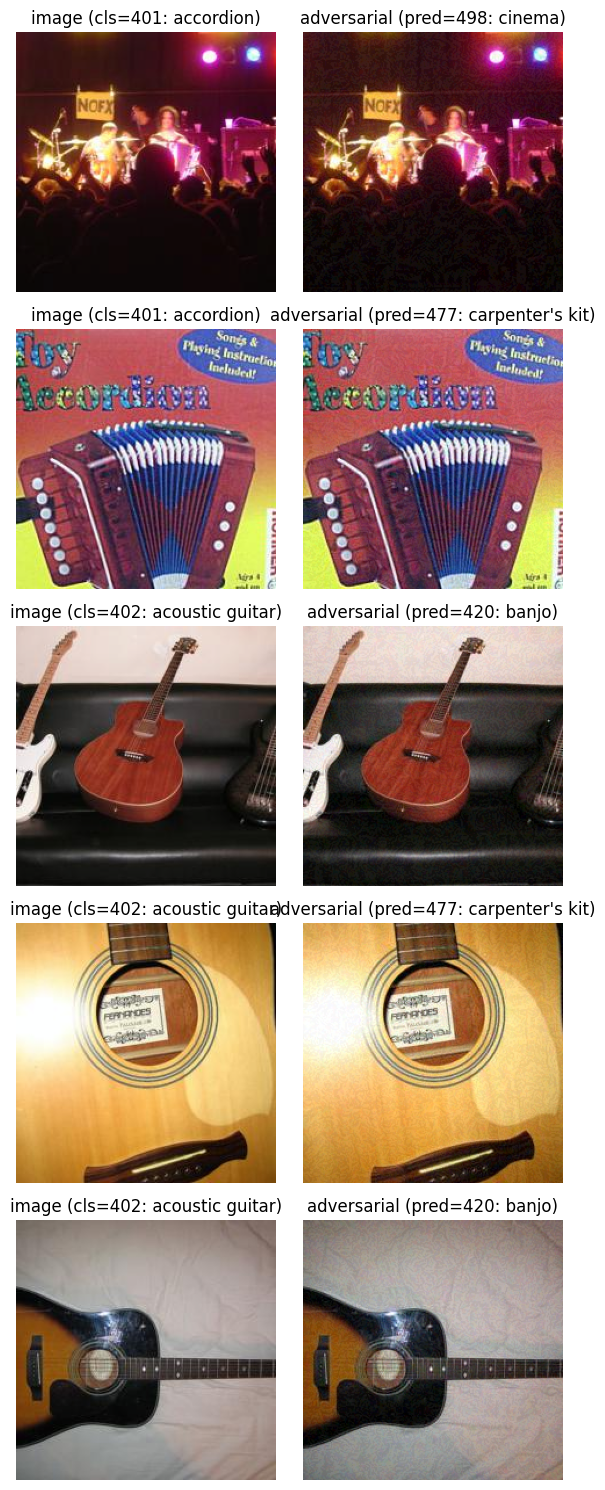

In [31]:
from matplotlib import pyplot as plt

#Visualize 5 misclassified sample
fig, axes = plt.subplots(len(orig_misclassified), 2, figsize=(6, 3 * len(orig_misclassified)))
for idx, (o, a, label, adv_p) in enumerate(orig_misclassified):
    
    orig_label = idx_to_label[label]      # e.g. "401: accordion"
    adv_pred   = idx_to_label[adv_p]
    # o, a (1, C, H, W). We need to remove batch D
    o_img = o.squeeze(0)  
    a_img = a.squeeze(0)

    for img_tensor, ax, title in [
        (o_img, axes[idx, 0], f"image (cls={orig_label})"),
        (a_img, axes[idx, 1], f"adversarial (pred={adv_pred})")
    ]:
        # (C, H, W) -> (H, W, C)
        img_vis = img_tensor.permute(1, 2, 0).cpu().numpy()
        img_vis = img_vis * std_norms + mean_norms
        img_vis = np.clip(img_vis, 0, 1)
        ax.imshow(img_vis)
        ax.set_title(title)
        ax.axis('off')

plt.tight_layout()

In [32]:
#Save to disk
from torchvision import utils

save_root = os.path.join(os.getcwd(), 'Adversarial Test Set 1')
if not os.path.exists(save_root): os.makedirs(save_root)

#Create folder like original:
for cls_idx, cls_name in enumerate(dataset.classes):
    dir_path = os.path.join(save_root, cls_name)
    os.makedirs(dir_path, exist_ok=True)

#Store image
for i in range(len(adv_tensor)):
    cls = dataset.classes[adv_labels[i]]
    img = adv_tensor[i]
    #Denormalization
    img_denorm = img * torch.tensor(std_norms).view(3,1,1) + torch.tensor(mean_norms).view(3,1,1)
    img_denorm = img_denorm.clamp(0,1)
    #Store toPNG
    utils.save_image(img_denorm, os.path.join(save_root, cls, f"adv_{i}.png"))

In [33]:
#Create Adversarial json.
with open(os.path.join(save_root, 'labels_list.json'), 'w', encoding='utf-8') as f:
    json.dump(idx_to_label, f, ensure_ascii=False, indent=2, separators=(',', ': '))
print(f"Adversarial json set has been stored: {save_root}")

Adversarial json set has been stored: F:\pythonProject\jupyterNotebook\code\ImageNet-1K\Adversarial Test Set 1


In [34]:
#Evaluate Performance Drop
adv_dataset = torchvision.datasets.ImageFolder(root=save_root, transform=plain_transforms)
#new dataloader
adv_loader  = DataLoader(adv_dataset, batch_size=32, shuffle=False, num_workers=4)
adv_top1_acc, adv_top5_acc = evaluate(model, adv_loader, device)

#Compare:top1_acc, top5_acc
print(f"[adversarial] Top-1: {adv_top1_acc:.2f}% | Top-5: {adv_top5_acc:.2f}%")
print(f"Compare: Top-1 Drop {top1_acc - adv_top1_acc:.2f}%; \n"
      f"Top-5 Drop {top5_acc - adv_top5_acc:.2f}%")

[adversarial] Top-1: 9.20% | Top-5: 40.40%
Compare: Top-1 Drop 80.40%; 
Top-5 Drop 59.00%


# Task 3: Per-pixel Attack with PGD

This notebook, based on task 1 and 2, would do the following：

1. Fast Projected Gradient Descent Attack (PGD). It is said that it's more powerful than FGSM and it's a multi-step attack.
2. calculate range
3. Generate sample and collect
4. Turn it to Tensor Dataset
5. Inference, and report new top1, top5.

In [35]:
import torch.nn.functional as F
#Define PGD attack. We still use ε = 0.02
def pgd_attack(image, target, model, class_subset, epsilon_norm, alpha_norm, iters):
    ori = image.clone().detach()
    pert = image.clone().detach().requires_grad_(True)
    
    for _ in range(iters):
        out = model(pert)[:, class_subset]
        loss = F.cross_entropy(out, target)
        model.zero_grad(); loss.backward()
        grad = pert.grad.data
        pert = pert + alpha_norm * grad.sign()
        pert = torch.max(torch.min(pert, ori+epsilon_norm), ori-epsilon_norm)
        pert = torch.max(torch.min(pert, max_pixel), min_pixel).detach().requires_grad_(True)
        pert = pert.detach().to(image.dtype).requires_grad_(True)
    return pert


In [36]:
#Parameter of PGD
epsilon_norm = eps_norm
pgd_steps = 10 #as multi-step set to 10.
alpha_norm = eps_norm / pgd_steps

In [37]:
#new sample of adversarial
adv_images2, adv_labels2, orig_mis2, orig_images2 = [], [], [], []
model.eval()
for imgs, targets in DataLoader(dataset, batch_size=1, shuffle=False):
    imgs, targets = imgs.to(device), targets.to(device)
    orig_images2.append(imgs.detach().clone())
    adv2 = pgd_attack(imgs, targets, model, test_cls, epsilon_norm, alpha_norm, pgd_steps)
    adv_images2.append(adv2.detach().clone())
    adv_labels2.append(targets.item())
    po = model(imgs)[:,test_cls].max(1)[1]; pa = model(adv2)[:,test_cls].max(1)[1]
    if po==targets and pa!=targets and len(orig_mis2)<5:
        orig_mis2.append((imgs.cpu(), adv2.cpu(), targets.item(), pa.item()))
adv_tensor2 = torch.cat(adv_images2)

print(f"PGD adversarial sample: {len(adv_tensor2)}, get mismatch: {len(orig_mis2)}")

PGD adversarial sample: 500, get mismatch: 5


In [38]:
std_tensor = torch.tensor(std_norms, device=device).view(1,3,1,1)
mean_tensor = torch.tensor(mean_norms, device=device).view(3,1,1)
errs2 = [
    ((adv - orig).abs() * std_tensor).max().item()
    for orig, adv in zip(orig_images2, adv_images2)
]

print(f"maximum L∞ range(initial range): {max(errs2):.4f}, average is {np.mean(errs):.4f}")

maximum L∞ range(initial range): 0.0200, average is 0.0200


In [39]:
print("Collected mismatches:", len(orig_mis2))

Collected mismatches: 5


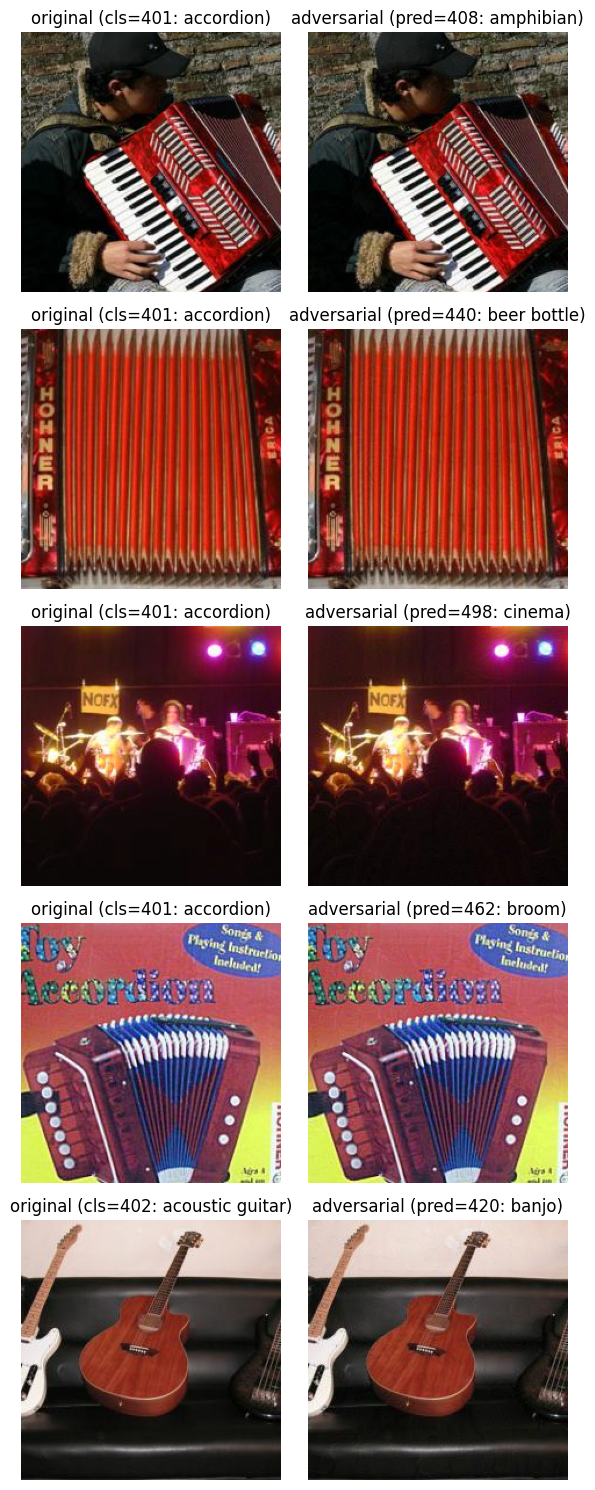

In [40]:
fig, axs2 = plt.subplots(len(orig_mis2),2,figsize=(6,3*len(orig_mis2)))

for idx, (o, a, gt, adv_p) in enumerate(orig_mis2):
    orig_label = idx_to_label[gt]      # e.g. "401: accordion"
    adv_pred   = idx_to_label[adv_p]
    o_img = o.squeeze(0).detach().cpu()
    a_img = a.squeeze(0).detach().cpu()
    for img_tensor, ax, title in [
        (o_img, axs2[idx, 0], f"original (cls={orig_label})"),
        (a_img, axs2[idx, 1], f"adversarial (pred={adv_pred})")
    ]:
        # (C, H, W) -> (H, W, C)
        img_vis = img_tensor.permute(1, 2, 0).numpy()
        img_vis = img_vis * std_norms + mean_norms
        img_vis = np.clip(img_vis, 0, 1)
        ax.imshow(img_vis)
        ax.set_title(title)
        ax.axis('off')

plt.tight_layout()
plt.show()

In [41]:
root2 = os.path.join(os.getcwd(),'Adversarial Test Set 2')
if not os.path.exists(root2): os.makedirs(root2)

#Create folder like original:
for cls_idx, cls_name in enumerate(dataset.classes):
    dir_path = os.path.join(root2, cls_name)
    os.makedirs(dir_path, exist_ok=True)
    
for i in range(len(adv_tensor2)):
    cls = dataset.classes[adv_labels2[i]]
    img = adv_tensor2[i]
    #Denormalization
    std_t  = torch.tensor(std_norms, dtype=img.dtype, device=img.device).view(3,1,1)
    mean_t = torch.tensor(mean_norms, dtype=img.dtype, device=img.device).view(3,1,1)
    
    img_denorm = img * std_t + mean_t
    img_denorm = img_denorm.clamp(0,1)
    #Store toPNG
    utils.save_image(img_denorm, os.path.join(root2, cls, f"adv_{i}.png"))

with open(os.path.join(root2, 'labels_list.json'), 'w', encoding='utf-8') as f:
    json.dump(idx_to_label, f, ensure_ascii=False, indent=2, separators=(',', ': '))
print(f"Adversarial json set has been stored: {root2}")

Adversarial json set has been stored: F:\pythonProject\jupyterNotebook\code\ImageNet-1K\Adversarial Test Set 2


In [42]:
#Evaluate Performance Drop
adv_dataset2 = torchvision.datasets.ImageFolder(root=root2,transform=plain_transforms)
#new dataloader
adv_loader2  = DataLoader(adv_dataset2, batch_size=32, shuffle=False, num_workers=4)
adv2_top1_acc, adv2_top5_acc = evaluate(model, adv_loader2, device)

#Compare:top1_acc, top5_acc
print(f"[adversarial] Top-1: {adv2_top1_acc:.2f}% | Top-5: {adv2_top5_acc:.2f}%")
print(f"Compare: Top-1 Drop {top1_acc - adv2_top1_acc:.2f}%; \n"
      f"Top-5 Drop {top5_acc - adv2_top5_acc:.2f}%")

[adversarial] Top-1: 0.40% | Top-5: 5.20%
Compare: Top-1 Drop 89.20%; 
Top-5 Drop 94.20%


# Task 4: Local Patch Attack (32×32)

We will use PGD but with higher ε (for instance,0.3 or 0.5）。

For each small graph, we use 32*32 area only for this adversarial attack

newly imported library：


random

In [47]:
import random

def patch_pgd_attack(img, target, model, class_subset,
                     epsilon_norm, alpha_norm, iters,
                     patch_size=32):
    """
    img:           input image of (1,C,H,W)
    target:        tag
    model         
    class_subset
    epsilon_norm:  L∞ budget
    alpha_norm:    step
    iters:         epochs
    """
    epsilon_norm = epsilon_norm.to(img.dtype)
    alpha_norm   = alpha_norm.to(img.dtype)
    min_p = min_pixel.to(img.dtype)
    max_p = max_pixel.to(img.dtype)
    ori = img.clone().detach()
    pert = img.detach().clone().requires_grad_(True)
    
    _, _, H, W = img.shape
    
    #Random choose, from left-top to count:
    top = random.randint(0, H - patch_size)
    left = random.randint(0, W - patch_size)
    bottom = top + patch_size
    right  = left + patch_size
    
    for _ in range(iters):
        out = model(pert)[:, class_subset]
        loss = F.cross_entropy(out, target)
        model.zero_grad(); loss.backward()
        grad = pert.grad.data
        
        
        
        # update only in batch area
        
        mask = torch.zeros_like(pert)
        mask[:, :, top:bottom, left:right] = 1.0
        
        pert = pert + mask * (alpha_norm * grad.sign())
        pert = torch.max(
            torch.min(pert, ori + mask * epsilon_norm),
            ori - mask * epsilon_norm
        )
        # grad_patch = grad[:, :, top:bottom, left:right]
        # pert[:, :, top:bottom, left:right] = (
        #     pert[:, :, top:bottom, left:right]
        #     + alpha_norm * grad_patch.sign()
        # )
        pert = torch.clamp(pert, min_p, max_p)
        pert = pert.detach().requires_grad_(True)
        # update = torch.zeros_like(pert)
        # update[:, :, top:bottom, left:right] = alpha_norm * grad.sign()[:, :, top:bottom, left:right]
        # pert = pert + update
        
        # map batch area to L∞ attack budget
        # pert[:, :, top:bottom, left:right] = torch.max(
        #     torch.min(pert[:, :, top:bottom, left:right],
        #               ori[:, :, top:bottom, left:right] + epsilon_norm),
        #     ori[:, :, top:bottom, left:right] - epsilon_norm
        # )
        
        # pert = torch.max(torch.min(pert, max_p), min_p).detach().requires_grad_(True)

    return pert


In [55]:
#As project stated, we can allow more epsilon.
epsilon = 0.5
pgd_steps = 10
alpha = eps_norm / pgd_steps * (0.5/0.02)
adv3_imgs, adv_labels3, mis3, orig3 = [], [], [],[]
model.eval()
for img, target in DataLoader(dataset, batch_size=1, shuffle=False):
    img, target = img.to(device), target.to(device)
    adv = patch_pgd_attack(
        img, target, model, test_cls,
        epsilon_norm=torch.tensor(epsilon/std_norms, device=device).view(1,3,1,1),
        alpha_norm=alpha, iters=pgd_steps,
        patch_size=32
    )
    
    with torch.no_grad():
        logits0 = model(img)[:, test_cls]     # [1, 100]
        p0 = logits0.argmax(dim=1)
        logits1 = model(adv)[:, test_cls]
        p1 = logits1.argmax(dim=1)
        
    adv_cpu = adv.detach().cpu()
    del adv
    
    adv3_imgs.append(adv_cpu)
    adv_labels3.append(target.item())
    orig3.append(img.detach().cpu())
    
    if p0.item() == target.item() and p1.item() != target.item() and len(mis3) < 5:
        mis3.append((img.detach().cpu(), adv_cpu, target.item(), p1.item()))
        
adv_tensor3 = torch.cat(adv3_imgs, dim = 0)
print(f"Patch-attack adversarial graph: {len(adv_tensor3)}, mismatched sample: {len(mis3)}")

Patch-attack adversarial graph: 500, mismatched sample: 5


In [56]:
std_tensor_cpu = torch.tensor(std_norms, dtype=torch.float32).view(1,3,1,1)

errs3 = []
for orig, adv in zip(orig3, adv3_imgs):
    diff = (adv - orig).abs() * std_tensor_cpu
    errs3.append(diff.max().item())
print(f"attack budget ε (Task4): {max(errs3):.4f}")

attack budget ε (Task4): 0.5000


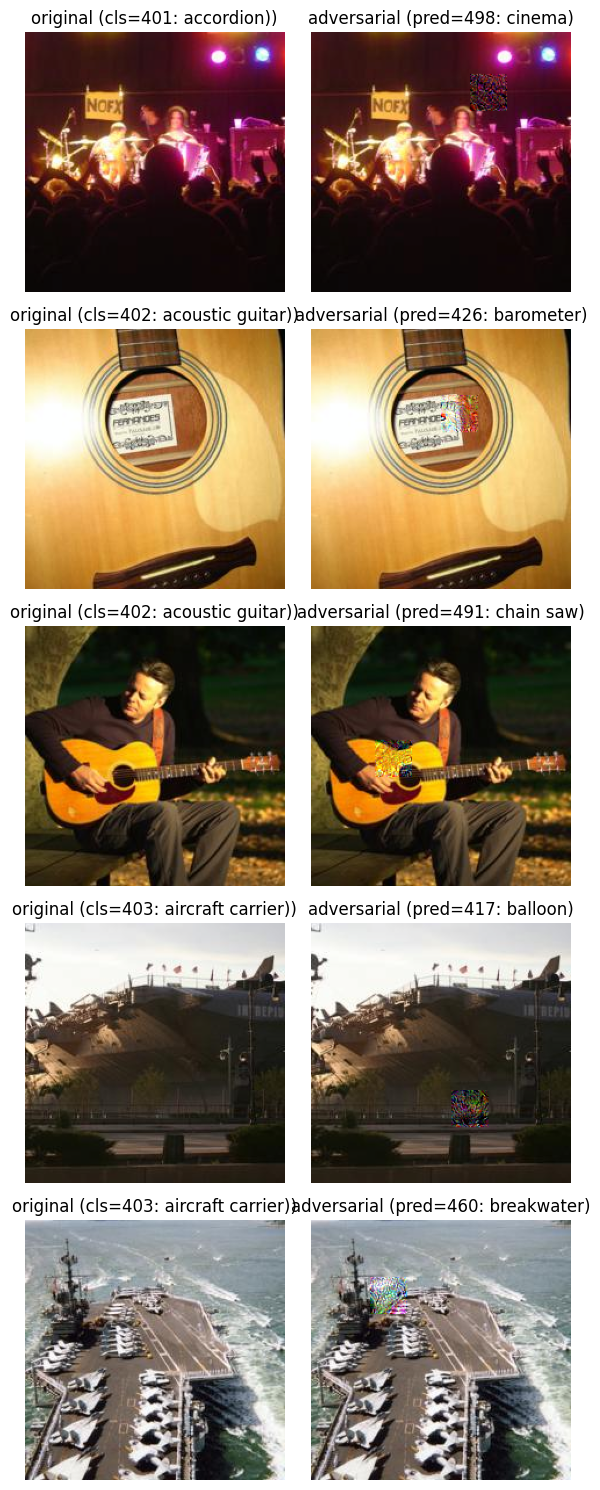

In [57]:
fig, axs3 = plt.subplots(len(mis3), 2, figsize=(6, 3*len(mis3)))
for idx, (o, a, gt, pr) in enumerate(mis3):
    orig_label = idx_to_label[gt]      # e.g. "401: accordion"
    adv_pred   = idx_to_label[pr]
    for img_tensor, ax, title in [
        (o.squeeze(0), axs3[idx,0], f"original (cls={orig_label}))"),
        (a.squeeze(0), axs3[idx,1], f"adversarial (pred={adv_pred})")
    ]:
        # (C, H, W) -> (H, W, C)
        img_vis = img_tensor.permute(1,2,0).numpy()
        img_vis = img_vis * std_norms + mean_norms
        img_vis = np.clip(img_vis, 0, 1)
        ax.imshow(img_vis)
        ax.set_title(title)
        ax.axis('off')
plt.tight_layout()
plt.show()

In [58]:
root3 = os.path.join(os.getcwd(),'Adversarial Test Set 3')
if not os.path.exists(root3): os.makedirs(root3)

#Create folder like original:
for cls_idx, cls_name in enumerate(dataset.classes):
    dir_path = os.path.join(root3, cls_name)
    os.makedirs(dir_path, exist_ok=True)
    
for i in range(len(adv_tensor3)):
    cls = dataset.classes[adv_labels3[i]]
    img = adv_tensor3[i]
    #Denormalization
    std_t  = torch.tensor(std_norms, dtype=img.dtype, device=img.device).view(3,1,1)
    mean_t = torch.tensor(mean_norms, dtype=img.dtype, device=img.device).view(3,1,1)
    
    img_denorm = img * std_t + mean_t
    img_denorm = img_denorm.clamp(0,1)
    #Store toPNG
    utils.save_image(img_denorm, os.path.join(root3, cls, f"adv_{i}.png"))

with open(os.path.join(root3, 'labels_list.json'), 'w', encoding='utf-8') as f:
    json.dump(idx_to_label, f, ensure_ascii=False, indent=2, separators=(',', ': '))
print(f"Adversarial json set has been stored: {root3}")

Adversarial json set has been stored: F:\pythonProject\jupyterNotebook\code\ImageNet-1K\Adversarial Test Set 3


In [61]:
#Evaluate Performance Drop
adv_dataset3 = torchvision.datasets.ImageFolder(root=root3,transform=plain_transforms)
#new dataloader
adv_loader3  = DataLoader(adv_dataset3, batch_size=32, shuffle=False, num_workers=4)
adv3_top1_acc, adv3_top5_acc = evaluate(model, adv_loader3, device)

#Compare:top1_acc, top5_acc
print(f"[adversarial] Top-1: {adv3_top1_acc:.2f}% | Top-5: {adv3_top5_acc:.2f}%")
print(f"Compare: Top-1 Drop {top1_acc - adv3_top1_acc:.2f}%; \n"
      f"Top-5 Drop {top5_acc - adv3_top5_acc:.2f}%")

[adversarial] Top-1: 46.00% | Top-5: 88.60%
Compare: Top-1 Drop 43.60%; 
Top-5 Drop 10.80%


# Task 5: Transfer to DenseNet-121 and Comparative Evaluation

No need to say more

In [62]:
from torchvision.models import densenet121
import pandas as pd

In [63]:
densenet = densenet121(weights='IMAGENET1K_V1').to(device)
densenet.eval()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\chengmin/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 38.9MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

# Start to evaluate
We will use DenseNet 121 to do something as prof. said.


In [65]:
dn_orig_top1, dn_orig_top5 = evaluate(densenet, dataloader, device)
dn_adv1_top1, dn_adv1_top5 = evaluate(densenet, adv_loader, device)
dn_adv2_top1, dn_adv2_top5 = evaluate(densenet, adv_loader2,device)
dn_adv3_top1, dn_adv3_top5 = evaluate(densenet, adv_loader3,device)

In [66]:
print(f"[DenseNet-121 on Original] Top-1: {dn_orig_top1:.2f}% | Top-5: {dn_orig_top5:.2f}%")
print(f"[DenseNet-121 on FGSM]     Top-1: {dn_adv1_top1:.2f}% | Top-5: {dn_adv1_top5:.2f}%")
print(f"[DenseNet-121 on PGD]      Top-1: {dn_adv2_top1:.2f}% | Top-5: {dn_adv2_top5:.2f}%")
print(f"[DenseNet-121 on Patch]    Top-1: {dn_adv3_top1:.2f}% | Top-5: {dn_adv3_top5:.2f}%")

[DenseNet-121 on Original] Top-1: 88.00% | Top-5: 98.40%
[DenseNet-121 on FGSM]     Top-1: 65.40% | Top-5: 91.20%
[DenseNet-121 on PGD]      Top-1: 70.20% | Top-5: 96.80%
[DenseNet-121 on Patch]    Top-1: 85.00% | Top-5: 98.00%


In [67]:
#Show result

results = pd.DataFrame({
    'Dataset': ['Original','FGSM','PGD','Patch'],
    'ResNet-34 Top-1': [top1_acc, adv_top1_acc, adv2_top1_acc, adv3_top1_acc],
    'ResNet-34 Top-5': [top5_acc, adv_top5_acc, adv2_top5_acc, adv3_top5_acc],
    'DenseNet-121 Top-1': [dn_orig_top1, dn_adv1_top1, dn_adv2_top1, dn_adv3_top1],
    'DenseNet-121 Top-5': [dn_orig_top5, dn_adv1_top5, dn_adv2_top5, dn_adv3_top5],
})


In [68]:
display(results)

Dataset  ResNet-34 Top-1  ResNet-34 Top-5  DenseNet-121 Top-1  \
0  Original             89.6             99.4                88.0   
1      FGSM              9.2             40.4                65.4   
2       PGD              0.4              5.2                70.2   
3     Patch             46.0             88.6                85.0   

   DenseNet-121 Top-5  
0                98.4  
1                91.2  
2                96.8  
3                98.0